In [21]:
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import TweedieRegressor
import scipy.stats as stats
from scipy.stats import uniform, randint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import InconsistentVersionWarning

# 1. Ignore version mismatch warnings from old pickled models
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

# 2. Ignore that delayed/Parallel warning
warnings.filterwarnings(
    "ignore",
    message="`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel`"
)

# 3. Ignore sklearn FutureWarnings (like force_int_remainder_cols)
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 40)

In [22]:
df = pd.read_csv("cleaned_medical_insurance_problem1.csv")
df

,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,dependents,bmi,smoker,alcohol_freq,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,systolic_bp,diastolic_bp,ldl,...,risk_score,total_claims_paid,chronic_count,hypertension,diabetes,asthma,copd,cardiovascular_disease,cancer_history,kidney_disease,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,1,27.4,Never,Never,2,0,0,4,121.0,76.0,123.8,...,0.5714,4672.59,1,0,0,0,0,0,0,0,0,1,0,1,0,2,0,1,0,0
1,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,0,30.5,Never,Daily,3,0,0,2,136.0,83.0,171.0,...,0.8681,1002.24,2,1,0,0,0,0,0,0,0,1,0,2,0,1,1,0,1,0
2,63,Female,North,Rural,305000.0,HS,Single,Employed,3,2,20.4,Never,Daily,1,0,0,2,137.0,96.0,69.2,...,0.6923,1220.04,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,36,Male,West,Rural,38900.0,Masters,Single,Employed,1,0,21.6,Never,Occasional,0,0,0,0,114.0,76.0,153.9,...,0.1978,0.00,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
4,21,Female,South,Suburban,83700.0,HS,Single,Employed,3,2,30.7,Never,Weekly,3,0,0,1,82.0,64.0,189.0,...,0.3187,1406.06,1,0,1,0,0,0,0,0,0,0,0,2,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83822,50,Male,West,Urban,127200.0,No HS,Married,Employed,2,0,28.2,Never,Occasional,0,0,0,1,115.0,74.0,102.5,...,0.3516,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
83823,42,Male,East,Suburban,21600.0,HS,Married,Employed,2,0,27.6,Never,Occasional,0,0,0,1,101.0,66.0,177.1,...,0.2637,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
83824,41,Male,West,Rural,81900.0,HS,Divorced,Unemployed,1,0,29.8,Former,Weekly,7,0,0,1,128.0,83.0,118.8,...,0.4505,2500.48,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
83825,51,Female,South,Urban,43400.0,Doctorate,Single,Unemployed,3,2,21.9,Never,Occasional,4,0,0,2,110.0,73.0,134.9,...,0.5604,1104.76,1,0,0,0,0,0,0,0,0,0,1,0,0,2,2,1,0,0


In [24]:
df = df.drop(["hypertension", "diabetes", "asthma", "copd", "cardiovascular_disease", "cancer_history", "kidney_disease", "arthritis", "mental_health", 
              'liver_disease', 'days_hospitalized_last_3yrs'], axis=1)

## Tweedie Regression

### 1. Define input features and target
### 2. Transform the input features
### 3. Train-test Split

In [28]:
target = "total_claims_paid"

y = df[target]
X = df.drop(columns=[target])

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder="passthrough"
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Fit model

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Params: {'tweedie__alpha': np.float64(5.623413251903491), 'tweedie__power': 1.7}

--- Train ---
MAE:  $1,122.64
RMSE: $2,237.96
R²:   -0.0542

--- Test ---
MAE:  $1,138.55
RMSE: $2,114.39
R²:   0.0869


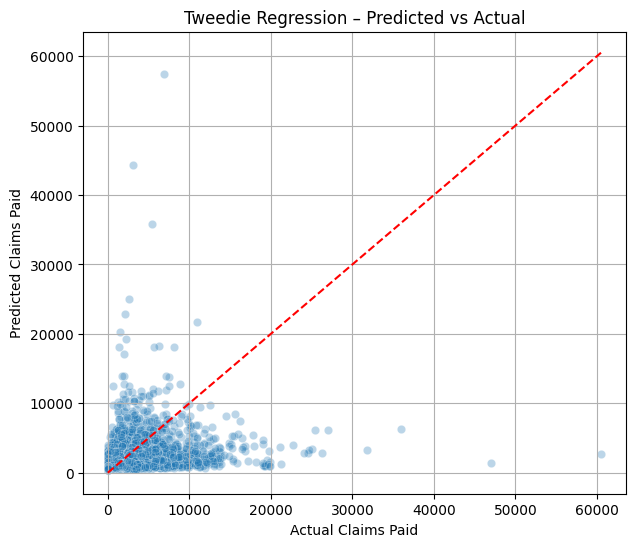

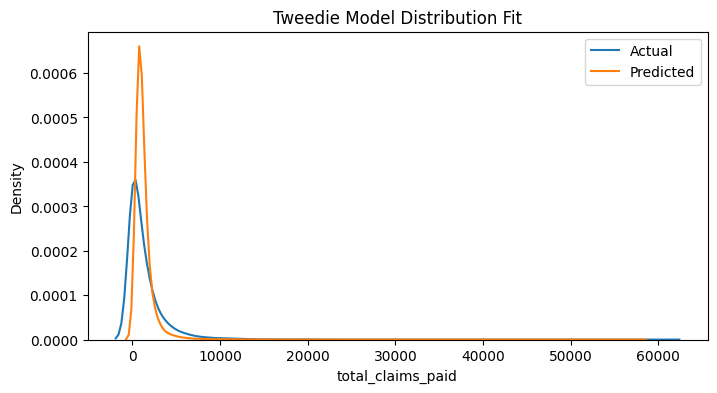

In [29]:
tweedie = TweedieRegressor(
    power=1.5,
    alpha=0.1,
    link="log",
    max_iter=5000
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("tweedie", tweedie)
])

param_grid = {
    "tweedie__power": [1.3, 1.5, 1.7, 1.9],
    "tweedie__alpha": np.logspace(-3, 2, 9)
}

grid = GridSearchCV(
    model,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)

# Use tuned model
best_model = grid.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


def report_metrics(label, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n{name} Metrics")
    print(f"MAE:  ${mae:,.2f}")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"R²:   {r2:.4f}")

report_metrics("Train", y_train, y_train_pred)
report_metrics("Test", y_test, y_test_pred)

plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.3)
plt.plot([0, y_test.max()], [0, y_test.max()], "r--")
plt.xlabel("Actual Claims Paid")
plt.ylabel("Predicted Claims Paid")
plt.title("Tweedie Regression – Predicted vs Actual")
plt.grid(True)
plt.show()


plt.figure(figsize=(8,4))
sns.kdeplot(y_test, label="Actual", bw_adjust=2)
sns.kdeplot(y_test_pred, label="Predicted", bw_adjust=2)
plt.legend()
plt.title("Tweedie Model Distribution Fit")
plt.show()

In [16]:
# Extract pipeline pieces
tweedie_model = best_model.named_steps["tweedie"]
ohe = best_model.named_steps["preprocessor"].named_transformers_["cat"]
scaler = best_model.named_steps["preprocessor"].named_transformers_["num"]

# Build feature name list
cat_features = ohe.get_feature_names_out(categorical_cols)
all_features = np.concatenate([numeric_cols, cat_features])

# Coefficients
coefs = tweedie_model.coef_

# Put into dataframe
coef_df = pd.DataFrame({
    "feature": all_features,
    "coefficient": coefs
}).sort_values("coefficient", key=abs, ascending=False)

coef_df.head(20)

,feature,coefficient
5,visits_last_year,0.234047
19,chronic_count,0.095553
18,risk_score,0.088862
35,is_high_risk,0.054320
7,days_hospitalized_last_3yrs,0.051220
20,hypertension,0.048329
29,mental_health,0.046098
6,hospitalizations_last_3yrs,0.043783
28,arthritis,0.039394
36,had_major_procedure,0.030676
